In [1]:
import getpass
user_id = getpass.getuser()

import sys
sys.path.append(f"/home/{user_id}/OTTEHR/")

from collections import Counter
from common import *
from googletrans import Translator
import matplotlib.pyplot as plt
from mimic_common import *

base_path = f"/home/{user_id}/OTTEHR/mimiciv_exp"
output_path = f"/home/{user_id}/OTTEHR/outputs/mimiciv"

2024-02-29 10:57:30.410682: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 10:57:30.447394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 10:57:30.447432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 10:57:30.448508: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 10:57:30.454640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

The goal is to study the fairness diagnosis ICD codes vs prescription for different races

Step 1: Select source and target samples 

In [2]:
df = pd.read_csv(os.path.join(base_path, "mimiciv/final_admission.csv"), converters={'diagnosis_icd_code': literal_eval, 'procedure_icd_code': literal_eval, 'drug': literal_eval})
display(df)

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod,diagnosis_icd_code,procedure_icd_code,drug
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,2180-05-06 23:30:00,0,F,52,2180,2014 - 2016,2180-09-09,"[5723, 78959, 5715, 07070, 496, 29680, 30981, ...",[5491],"[Acetaminophen, Sodium Chloride 0.9% Flush, F..."
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,...,2180-06-26 21:31:00,0,F,52,2180,2014 - 2016,2180-09-09,"[07071, 78959, 2875, 2761, 496, 5715, V08, 3051]",[5491],"[Rifaximin, Lactulose, Calcium Carbonate, Furo..."
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,...,2180-08-06 01:44:00,0,F,52,2180,2014 - 2016,2180-09-09,"[07054, 78959, V462, 5715, 2767, 2761, 496, V0...",[5491],"[Albumin 25% (12.5g / 50mL), Calcium Carbonate..."
3,10000117,27988844,2183-09-18 18:10:00,2183-09-21 16:30:00,NaN,OBSERVATION ADMIT,P75S70,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Other,...,2183-09-18 20:20:00,0,F,48,2174,2008 - 2010,NaN,"[S72012A, W010XXA, Y93K1, Y92480, K219, E7800,...",[0QS734Z],"[Senna, Bisacodyl, Cepacol (Sore Throat Lozeng..."
4,10000560,28979390,2189-10-15 10:30:00,2189-10-17 15:00:00,NaN,SURGICAL SAME DAY ADMISSION,P08ZLF,PHYSICIAN REFERRAL,HOME,Other,...,NaN,0,F,53,2189,2008 - 2010,NaN,"[1890, V1582, V1201]",[5551],"[Scopolamine Patch, Ketorolac, Lorazepam, Pota..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220848,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00,NaN,EW EMER.,P75BG6,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,...,2149-01-08 18:12:00,0,F,46,2147,2017 - 2019,NaN,"[T8141XA, E1110, K632, D682, L02211, T83728A, ...","[0J980ZZ, 0WPF0JZ, 05HY33Z]","[Insulin, Potassium Chloride, Insulin, Insulin..."
220849,19999828,29734428,2147-07-18 16:23:00,2147-08-04 18:10:00,NaN,EW EMER.,P16C7J,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,...,2147-07-18 17:34:00,0,F,46,2147,2017 - 2019,NaN,"[T8131XA, T8183XA, K632, D6851, N390, Y838, Y9...","[0HR7X74, 0HBJXZZ, 0HBHXZZ, 02HV33Z, 3E0436Z]","[Insulin, Potassium Chloride (Powder), Acetami..."
220850,19999840,21033226,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,EW EMER.,P58A9J,EMERGENCY ROOM,DIED,Other,...,2164-09-10 14:46:00,1,M,58,2164,2008 - 2010,2164-09-17,"[3453, 51881, 5070, 5180, 42741, 43821, 43811,...","[9604, 9672, 966, 0331, 0331]","[Potassium Chloride, Bisacodyl, Phenytoin, 0.9..."
220851,19999840,26071774,2164-07-25 00:27:00,2164-07-28 12:15:00,NaN,EW EMER.,P506DE,EMERGENCY ROOM,HOME,Other,...,2164-07-25 01:20:00,0,M,58,2164,2008 - 2010,2164-09-17,"[43491, 43820, 34590, 43811, 4019, 2724, 3051]","[8891, 8841]","[Metoprolol Tartrate, Sodium Chloride 0.9% Fl..."


In [3]:
# Display all races
all_races = df['race']
Counter(all_races)

Counter({'WHITE': 144363,
         'BLACK/AFRICAN AMERICAN': 24628,
         'UNKNOWN': 8291,
         'OTHER': 8015,
         'WHITE - OTHER EUROPEAN': 4210,
         'HISPANIC OR LATINO': 3622,
         'HISPANIC/LATINO - PUERTO RICAN': 3458,
         'ASIAN': 3198,
         'ASIAN - CHINESE': 2974,
         'BLACK/CAPE VERDEAN': 2314,
         'HISPANIC/LATINO - DOMINICAN': 2004,
         'WHITE - RUSSIAN': 1857,
         'UNABLE TO OBTAIN': 1298,
         'BLACK/CARIBBEAN ISLAND': 1264,
         'PATIENT DECLINED TO ANSWER': 1259,
         'BLACK/AFRICAN': 1033,
         'PORTUGUESE': 816,
         'ASIAN - SOUTH EAST ASIAN': 789,
         'WHITE - BRAZILIAN': 634,
         'HISPANIC/LATINO - GUATEMALAN': 629,
         'ASIAN - ASIAN INDIAN': 619,
         'WHITE - EASTERN EUROPEAN': 571,
         'AMERICAN INDIAN/ALASKA NATIVE': 491,
         'HISPANIC/LATINO - SALVADORAN': 446,
         'HISPANIC/LATINO - COLUMBIAN': 283,
         'HISPANIC/LATINO - MEXICAN': 267,
         'MULTI

In [4]:
# If source_num and target_num are not the same, we cannot perform exact OT mapping
# we may get an unrealistic counterpart, and the prediction may be unreliable

source_num = 1000
target_num = 1000
selected_df = select_samples(df, 'race', 'WHITE', 'ASIAN', source_num, target_num)

In [5]:
source_features, source_labels, target_features, target_labels = gen_code_feature_label(selected_df, 'race', 'WHITE', 'ASIAN', 'diagnosis_icd_code', 'drug')

code is: S72145A
code is: W010XXA
code is: Y92121
code is: I120
code is: N186
code is: E1122
code is: E1142
code is: D62
code is: E1151
code is: D631
code is: E7800
code is: Z992
code is: Z794
code is: Z89421
code is: Z87891
code is: 57480
code is: 41401
code is: V4582
code is: 412
code is: 462
code is: C20
code is: K567
code is: J45909
code is: N183
code is: E669
code is: Z6835
code is: Z8589
code is: T80211A
code is: A4159
code is: R6521
code is: E43
code is: Z681
code is: A0472
code is: Y848
code is: Y92018
code is: R000
code is: I951
code is: R1032
code is: R1031
code is: N319
code is: N39498
code is: Z9049
code is: Z90710
code is: Z90722
code is: Z9079
code is: G629
code is: I890
code is: R5382
code is: Z86711
code is: Z87891
code is: R110
code is: I441
code is: D6959
code is: F4323
code is: 41401
code is: 42823
code is: 5990
code is: 99672
code is: 4271
code is: 4111
code is: 4280
code is: 42731
code is: 25000
code is: 41400
code is: 32723
code is: 40390
code is: 5859
code is: 27

/home/wanxinli/OTTEHR/mimic_common.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  source_labels = np.array(list(source_df[label_name]))
/home/wanxinli/OTTEHR/mimic_common.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  target_labels = np.array(list(target_df[label_name]))


In [6]:
source_features.shape

(1000, 4060)

In [7]:
print(source_labels, target_labels)

[list(['DiphenhydrAMINE', 'LORazepam', 'Docusate Sodium', 'HYDROmorphone (Dilaudid)', 'Nephrocaps', 'Neomycin-Polymyxin-Bacitracin', 'Bisacodyl', 'Insulin', 'HYDROmorphone (Dilaudid)', 'Bisacodyl', 'Heparin', 'Pantoprazole', 'Senna', 'Vitamin D', 'Sodium Chloride 0.9%', 'Ondansetron', 'Acetaminophen', 'Heparin Dwell (1000 Units/mL)', 'Epoetin Alfa', 'OxyCODONE (Immediate Release)', 'Vitamin D', 'Dextrose 50%', 'Atorvastatin', 'Heparin Dwell (1000 Units/mL)', 'Epoetin Alfa', 'HYDROmorphone (Dilaudid)', 'Calcium Carbonate', 'Lisinopril', 'DiphenhydrAMINE', 'Neomycin-Polymyxin-Bacitracin', 'Sodium Chloride 0.9%', 'Aspirin', 'Glucose Gel', 'Sodium Chloride 0.9%', 'Heparin Dwell (1000 Units/mL)', 'Sodium Chloride 0.9%  Flush', 'Heparin Dwell (1000 Units/mL)', 'Heparin (Hemodialysis)', 'Glucagon'])
 list(['Clopidogrel', 'Hydrocodone-Acetaminophen', 'Docusate Sodium', 'Morphine Sulfate', 'Sodium Chloride 0.9%  Flush', 'Pneumococcal Vac Polyvalent', 'Morphine Sulfate', 'Aspirin', 'Morphine Sul

In [8]:
print(source_features.shape, target_features.shape)

(1000, 4060) (1000, 4060)


Step 2: Optimal transport (matching between source and target features)

In [9]:
source_measure = np.ones((source_features.shape[0],))/source_features.shape[0]
target_measure = np.ones((target_features.shape[0],))/target_features.shape[0]
M = ot.dist(target_features, source_features, metric='sqeuclidean')
G = ot.emd(source_measure, target_measure, M)
row_sums = G.sum(axis=1)

normalized_G = G / row_sums[:, np.newaxis]
transp = G / np.sum(G, axis=1)[:, None]
transp[~ np.isfinite(transp)] = 0
trans_target_features = np.dot(transp, source_features)

trans_target_labels = [source_labels[int(i)] for i in np.dot(transp, np.arange(len(source_labels)))]
print(trans_target_labels)



[['Aspirin', 'Potassium Chloride', 'Oxycodone-Acetaminophen', 'Sodium Chloride 0.9%  Flush', 'Milk of Magnesia', 'Simvastatin', 'Acetaminophen', 'Neostigmine', 'Sodium Chloride 0.9%  Flush', 'Metoclopramide', 'Cepacol (Menthol)', 'Pneumococcal Vac Polyvalent', 'Carvedilol', 'Docusate Sodium (Liquid)', 'Digoxin', 'Warfarin', 'Furosemide', 'Sodium Chloride 0.9%  Flush', 'Ranitidine', 'Simvastatin', 'Propofol', 'Propofol', 'D5W', 'Norepinephrine', 'D5W', 'Nitroglycerin', 'Furosemide', 'Calcium Gluconate', 'Atropine Sulfate', 'D5W', 'Epinephrine', 'Bisacodyl', 'Temazepam', 'Digoxin', 'Morphine Sulfate', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Acetaminophen', 'Aspirin EC', 'Acetaminophen', 'Pantoprazole', 'Warfarin', 'Pneumococcal Vac Polyvalent', 'Glycopyrrolate', 'Metoprolol Tartrate', 'SW', 'Potassium Chloride', 'Sucralfate', 'Dextrose 50%', 'Ascorbic Acid', 'Metoprolol Tartrate', 'Docusate Sodium', 'Potassium Chloride', 'Melatonin', 'Morphine Sulfate', 'LR', 'Albumin 5% (25g / 500m

Step 3: Check if prescription changes significantly between an example with its counterpart 

In [10]:
def calc_stats(source_drug_list, target_drug_list):
    """ 
    Calculate the difference score, and drug unfairness score mapping between drug_list1 and drug_list2, 
    to assess the dissimilarity in prescription
    :param list[str] drug_list1: a drug list for a source admission
    :param list[str] drug_list2: a drug list for a target admission

    :returns:
        - float diff_score: overall difference score between two admissions for all drugs
        - map[list[float]] drug_unfairness_score: unfairness score (value, formatted in list of 1 element) for each drug (key)\
            Interpretation of the unfairness scores:
            Larger absolute value indicates more unfairness, \
            Positive value indicates the drug is prescribed more for source group, \
            Negative value indicates the drug is prescribed more for target group
    """
    
    overlap_count = 0
    source_counter = Counter(source_drug_list)
    target_counter = Counter(target_drug_list)
    drug_unfairness_score = {} # keys being drug name, values being score

    for target_drug, _ in target_counter.items():
        drug_unfairness_score[target_drug] = [-1] # initialize drug_unfairness_score

    for source_drug, source_count in source_counter.items():
        drug_unfairness_score[source_drug] = [1] # initialize drug_unfairness_score
        if source_drug in target_counter:
            overlap_count += min(target_counter[source_drug], source_count) 

            # update drug_score if key presents in both lists
            drug_unfairness_score[source_drug] = [(source_count - target_counter[source_drug])/max(source_count, target_counter[source_drug])] 
    diff_score = 1-overlap_count/(len(source_drug_list)+len(target_drug_list)-overlap_count)
    return diff_score, drug_unfairness_score

In [11]:
def combine_drug_score(drug_unfairness_score_1, drug_unfairness_score_2):
    """ 
    Combine two drug scores from calc_stats (first returned value)

    :returns: the combined drug score
    """
    combined_drug_unfairness_score = {}
    for key in drug_unfairness_score_1:
        if key in drug_unfairness_score_2:
            combined_drug_unfairness_score[key] = drug_unfairness_score_1[key] + drug_unfairness_score_2[key]
        else:
            combined_drug_unfairness_score[key] = drug_unfairness_score_1[key]

    # Add keys from drug_score_2 not already present in combined_drug_score
    for key in drug_unfairness_score_2:
        if key not in combined_drug_unfairness_score:
            combined_drug_unfairness_score[key] = drug_unfairness_score_2[key]
    return combined_drug_unfairness_score

In [12]:
def avg_drug_score(drug_unfairness_score):
    """
    Average the fairness score for each drug

    :returns: the averaged fairness drug score map
    """
    for drug, scores in drug_unfairness_score.items():
        drug_unfairness_score[drug] = np.mean(scores)
    return drug_unfairness_score

In [13]:
def translate_to_chinese(text):
    """ 
    Translate the text to Chinese
    """
    
    translator = Translator()
    translation = translator.translate(text, dest='zh-cn')
    return translation.text

In [14]:
diff_scores = []
final_drug_unfairness_score = {}
for target_label, trans_target_label in zip(target_labels, trans_target_labels):
    diff_score, drug_unfairness_score = calc_stats(target_label, trans_target_label)
    diff_scores.append(diff_score)
    final_drug_unfairness_score = combine_drug_score(final_drug_unfairness_score, drug_unfairness_score)
final_drug_unfairness_score = avg_drug_score(final_drug_unfairness_score)
final_drug_unfairness_score = {k: v for k, v in sorted(final_drug_unfairness_score.items(), key=lambda item: item[1], reverse=False)}
print(final_drug_unfairness_score)

# write the final_drug_unfairness_score to output file
# output_file = os.path.join(output_path, 'drug_unfairness_score.txt')
# with open(output_file, 'w') as f:
#     for key, value in final_drug_unfairness_score.items():
#         f.write(f"{key}, {translate_to_chinese(key)}, {value}\n")

{'Melatonin': -1.0, 'venetoclax': -1.0, 'Isavuconazonium Sulfate': -1.0, 'famciclovir': -1.0, 'COQ10 200mg': -1.0, 'Palivizumab': -1.0, 'Dextromethorphan Poly Complex': -1.0, 'Tolterodine': -1.0, 'DULoxetine': -1.0, 'Dexamethasone Oral Soln (0.1mg/1mL)': -1.0, 'Adderall': -1.0, 'Pletal': -1.0, 'Fluticasone-Salmeterol Diskus (100/50)': -1.0, 'Papain-Urea Ointment': -1.0, 'Pulmozyme': -1.0, 'gabapentin': -1.0, 'methad': -1.0, 'OxycoDONE': -1.0, 'Erythromycin Ethylsuccinate Suspension': -1.0, 'Methadone (Oral Solution)  2 mg/1 mL': -1.0, 'OxycoD': -1.0, 'Zinc Chloride': -1.0, 'NS (Irrigation Bottle)': -1.0, 'Vancomycin Enema': -1.0, 'Avapro': -1.0, 'rOPINIRole': -1.0, 'Systane': -1.0, 'Muro 128': -1.0, 'Topiramate (Topamax)': -1.0, 'Dabigatran Etexilate': -1.0, 'Xopenex Neb': -1.0, 'Amiloride HCl': -1.0, 'ValGANCIclovir ': -1.0, 'Mycophenolate': -1.0, 'Memantine': -1.0, 'Aspirin-Caffeine-Butalbital': -1.0, 'Ledipasvir/Sofosbuvir': -1.0, 'Everolimus': -1.0, 'HYDROcodone-Acetaminophen (5mg-

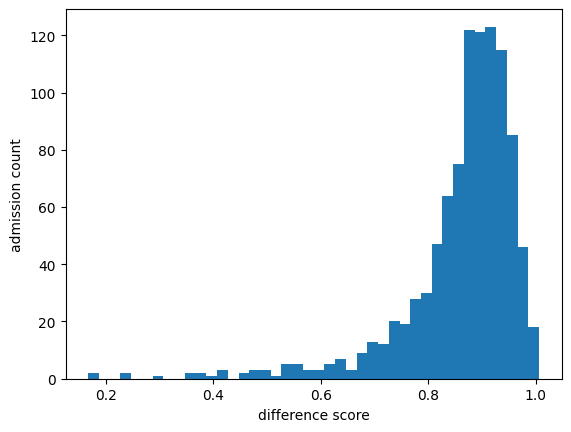

In [15]:
# Plot histogram of the difference score for all admissions

bin_width = 0.02
plt.hist(diff_scores, bins=np.arange(min(diff_scores), max(diff_scores) + bin_width, bin_width))
plt.xlabel('difference score')
plt.ylabel('admission count')
plt.show()

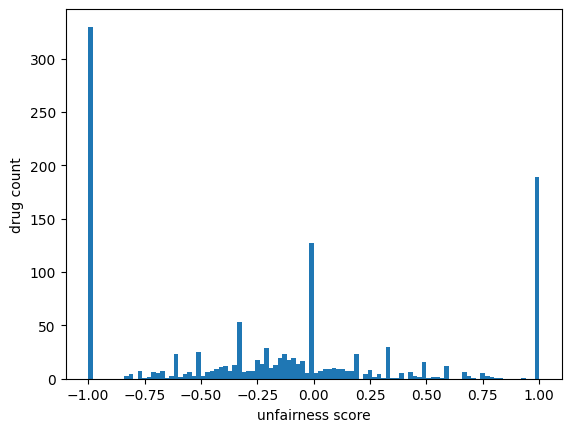

In [16]:
# Plot histogram of the drug unfairness scores for all drugs
# Interpretation of the unfairness scores:
# larger absolute value indicates more unfairness, \
# positive value indicates the drug is prescribed more for white
# negative value indicates the drug is prescribed more for asian


bin_width = 0.02
plt.hist(final_drug_unfairness_score.values(), bins=np.arange(min(final_drug_unfairness_score.values()), max(final_drug_unfairness_score.values()) + bin_width, bin_width))
plt.xlabel('unfairness score')
plt.ylabel('drug count')
plt.show()

In [29]:
white_drugs = [key for key, value in final_drug_unfairness_score.items() if value == [1.0]]
print(white_drugs)
asian_drugs = [key for key, value in final_drug_unfairness_score.items() if value == [-1.0]]
print(asian_drugs)

['Ampicillin', 'Leuprolide Acetate', 'ATRIPLA ', 'Oxaliplatin', 'Oxaliplatin Desensitization', 'Portia', 'Neomycin Sulfate', 'Glyburide Prestab', 'Isosorbide Dinitrate ER', 'Hepatitis B Immu Glob (HepaGam B)', 'Hepatitis B Immun Globulin (HepaGam B)', 'AMOXicillin', 'Adefovir', 'Hepsera', 'Trandolapril', 'Metoprolol Tart 5mg/5mL 5mL VIAL', 'Morphine Sulfate 2mg/1mL 1mL SYR', 'Haloperidol 5mg/1mL 1mL VIAL', 'Betamethasone Dipro 0.05% Cream', 'Evista', 'Varicella Virus Vaccine', 'IDArubicin', 'Tretinoin (ATRA-All Transretinoic Acid)', 'Fluorouracil', 'pilocarpine HCl', '5 Syringes (NS)', 'Peginterferon Alfa-2a', 'Hydrocortisone Na Succ', 'Chlordiazepoxide HCl', 'Heparin Flush CRRT (5000 Units/mL)', 'Mucinex', 'Mupirocin Cream 2%', 'Multivitamins W/minerals Chewable', 'Omnipred', 'XIBROM', 'Hemabate', 'Iohexol 240 (Omnipaque 240)', 'Erlotinib', 'glyco', 'LevoFLOXacin', 'OxyCODONE SR (OxyCONTIN)', 'OXALIplatin', 'sodium bicar', 'sodium bic', 'Anidulafungin', 'Potassium Chl 40 mEq / 1000 mL

Explanations from ChatGPT for drugs with unfairness score 1.0 and -1.0

Common Features of Drugs Used More Often for White People (unfairness score 1.0):

Chemical Composition: Many of these drugs have chemical names that sound familiar in Western medicine, such as Ampicillin, Glyburide, Metoprolol, Morphine, Betamethasone, etc.

Traditional Medications: Some drugs are commonly used in Western medical practices for conditions prevalent in white populations, such as Oxaliplatin for cancer treatment, Adefovir for hepatitis B, OxyCODONE for pain management, and Haloperidol for psychiatric disorders.

Brand Names: The list contains both generic and brand names of medications, indicating a mix of patented and generic drugs, which are commonly prescribed in Western healthcare systems.

Specialized Treatments: Some drugs like ATRIPLA, used in HIV treatment, indicate specific medical conditions or treatments that might be more prevalent or prioritized in white populations.

Standard Medical Practices: Many drugs in the list are commonly used in standard medical practices, such as antibiotics like Ampicillin and AMOXicillin, reflecting common health conditions and treatment protocols in white populations.

Common Features of Drugs Used More Often for Asian People (unfairness score -1.0):

Traditional Medications: Some drugs may have origins in Asian traditional medicine or be more commonly prescribed in Asian healthcare systems. This includes medications like Tolterodine and Pletal.

Specific Health Concerns: Drugs like Adderall for ADHD, which may be more commonly diagnosed and treated in Asian populations, could indicate different healthcare priorities or practices.

Specialized Treatments: Medications like Rituximab, Ledipasvir/Sofosbuvir, and Darunavir are used for conditions like autoimmune diseases, hepatitis C, and HIV, respectively, which might have different prevalence rates or treatment approaches in Asian populations.

Generic Names: While there are some brand names in the list, there is a higher prevalence of generic drug names, which might indicate different pharmaceutical preferences or availability in Asian healthcare systems.

Chronic Conditions: Drugs like Gabapentin, used for neuropathic pain, and valsartan, used for hypertension, may reflect a higher prevalence of certain chronic conditions in Asian populations.